# Распознавание рукописных символов на TensorFlow

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST/", one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


## Softmax-регрессия (нейронная сеть без скрытых слоев)

В качестве модели для обучения рассмотрим softmax-регрессию. Это обобщение логистической регресии на случай нескольких классов: чтобы получить "вероятности"  классов применяем softmax-функцию к вектору получившихся ненормализованных оценок:

$$softmax(x)_j = \frac{\exp{(x_j)}}{\sum_i exp{(x_i)}}$$

In [13]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

In [14]:
x = tf.placeholder(tf.float32, [None, 784], name="x1") 
W = tf.Variable(tf.zeros([784, 10]), name="W1")
b = tf.Variable(tf.zeros([10]), name="b1")

In [15]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10], name="y_1")

В качестве функции потерь используем стандартную для логистической регрессии перекрестную энтропию (cross-entropy):

$$H_t(y) = - \sum_i t_i \log (y_i),$$

где $y$ -- предсказанное значение, а $t$ -- исходная разметка (правильный ответ).


In [16]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

In [17]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

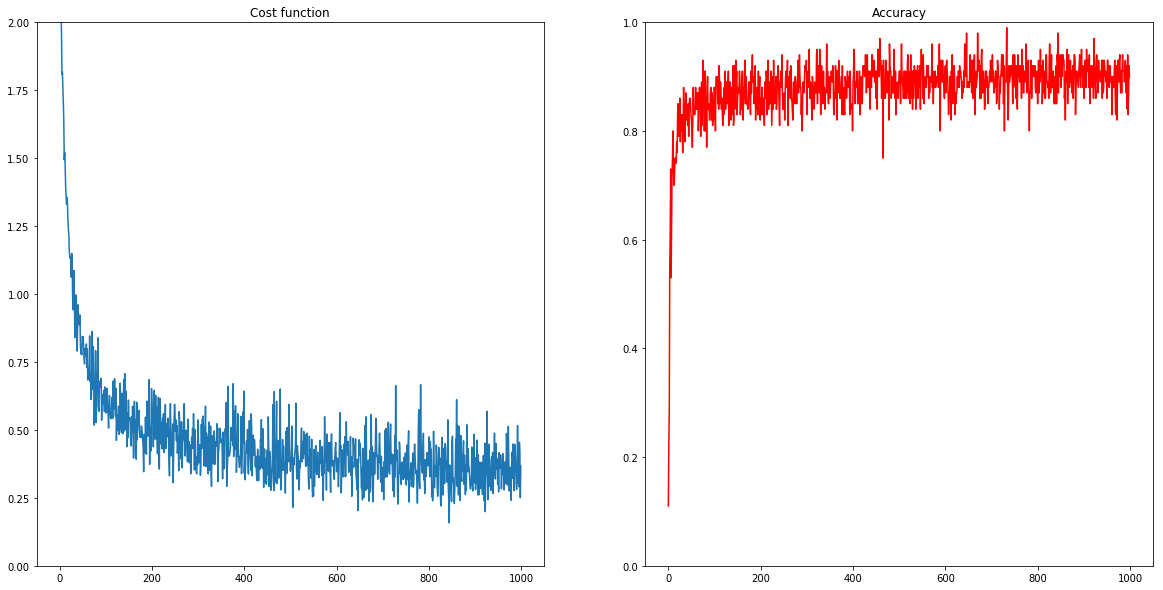

In [18]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cost_list = []
accuracy_list = []
n = 1000
for i in range(n):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, cost, accur = sess.run([train_step, cross_entropy, accuracy],
                              feed_dict={x: batch_xs, y_: batch_ys})    
    cost_list.append(cost)
    accuracy_list.append(accur)
     
ax1.plot(range(0, n), cost_list)
ax1.set_title("Cost function")
ax1.set_ylim(0, 2)
ax2.plot(range(0, n), accuracy_list, c='r')
ax2.set_title("Accuracy")
ax2.set_ylim(0, 1)
#plt.tight_layout()
plt.show()

In [19]:
print("Accuracy: %s" % sess.run(accuracy, feed_dict = {x: mnist.test.images, y_: mnist.test.labels}))

Accuracy: 0.91


Итак, точность предсказания на тестовом множестве для модели softmax-регрессии получилась приблизительно равна 91%. Попробуем улучшить точность с помощью более сложных моделей.

## Визуализируем цифры

Сделаем предсказание на тестовом множестве и посмотрим на несколько цифр из тестовой выборки.

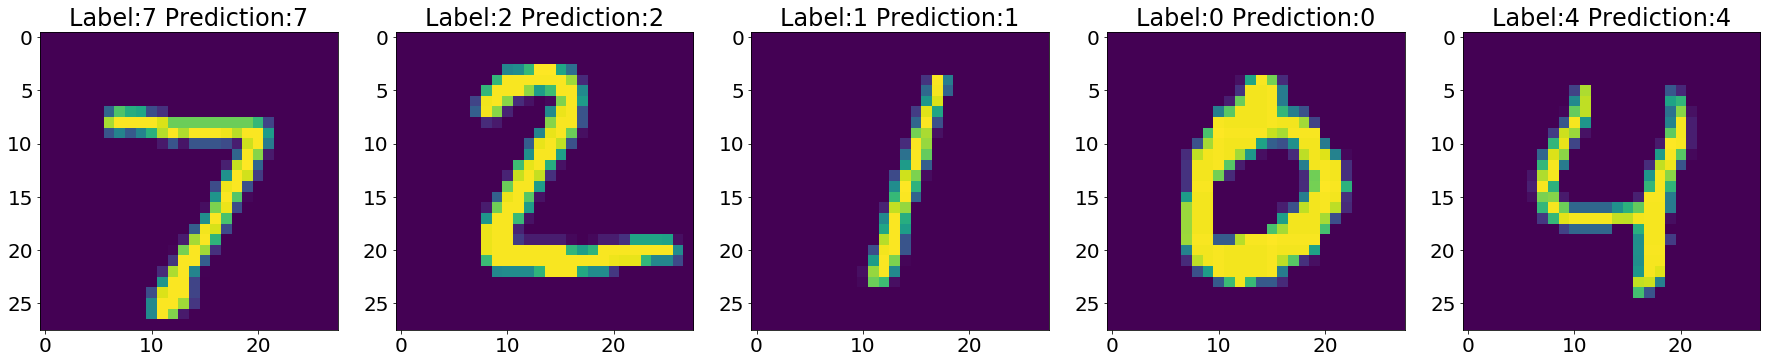

In [20]:
test_images = mnist.test.images
test_images_labels = np.argmax(mnist.test.labels, axis=1)
pred = tf.argmax(y, 1)
pred = sess.run(pred, feed_dict = {x: mnist.test.images})

import matplotlib as mpl
mpl.rcParams['font.size'] = 20   
def show_digits(images_array, image_labels, predictions, indices = range(5)):
    columns = 5
    rows = len(indices)//columns + (0 if len(indices)%columns == 0 else 1)        
    fig = plt.figure(figsize=(25, 25))        
    for i, ind in enumerate(indices):    
        ax = fig.add_subplot(rows, columns, i+1)      
        image = np.reshape(images_array[ind], [28, 28])
        str_title = "Label:" + str(image_labels[ind]) + " Prediction:" + str(predictions[ind])
        ax.set_title(str_title)
        plt.imshow(image)    
    plt.tight_layout()
    plt.show()

show_digits(test_images, test_images_labels, pred, range(5))

Найдем индексы изображений, которые были классифицированы ошибочно, и посмотрим как выглядели исходные данные.

Proportion of errors: 0.09 Accuracy: 0.91
Total wrong predictions: 900


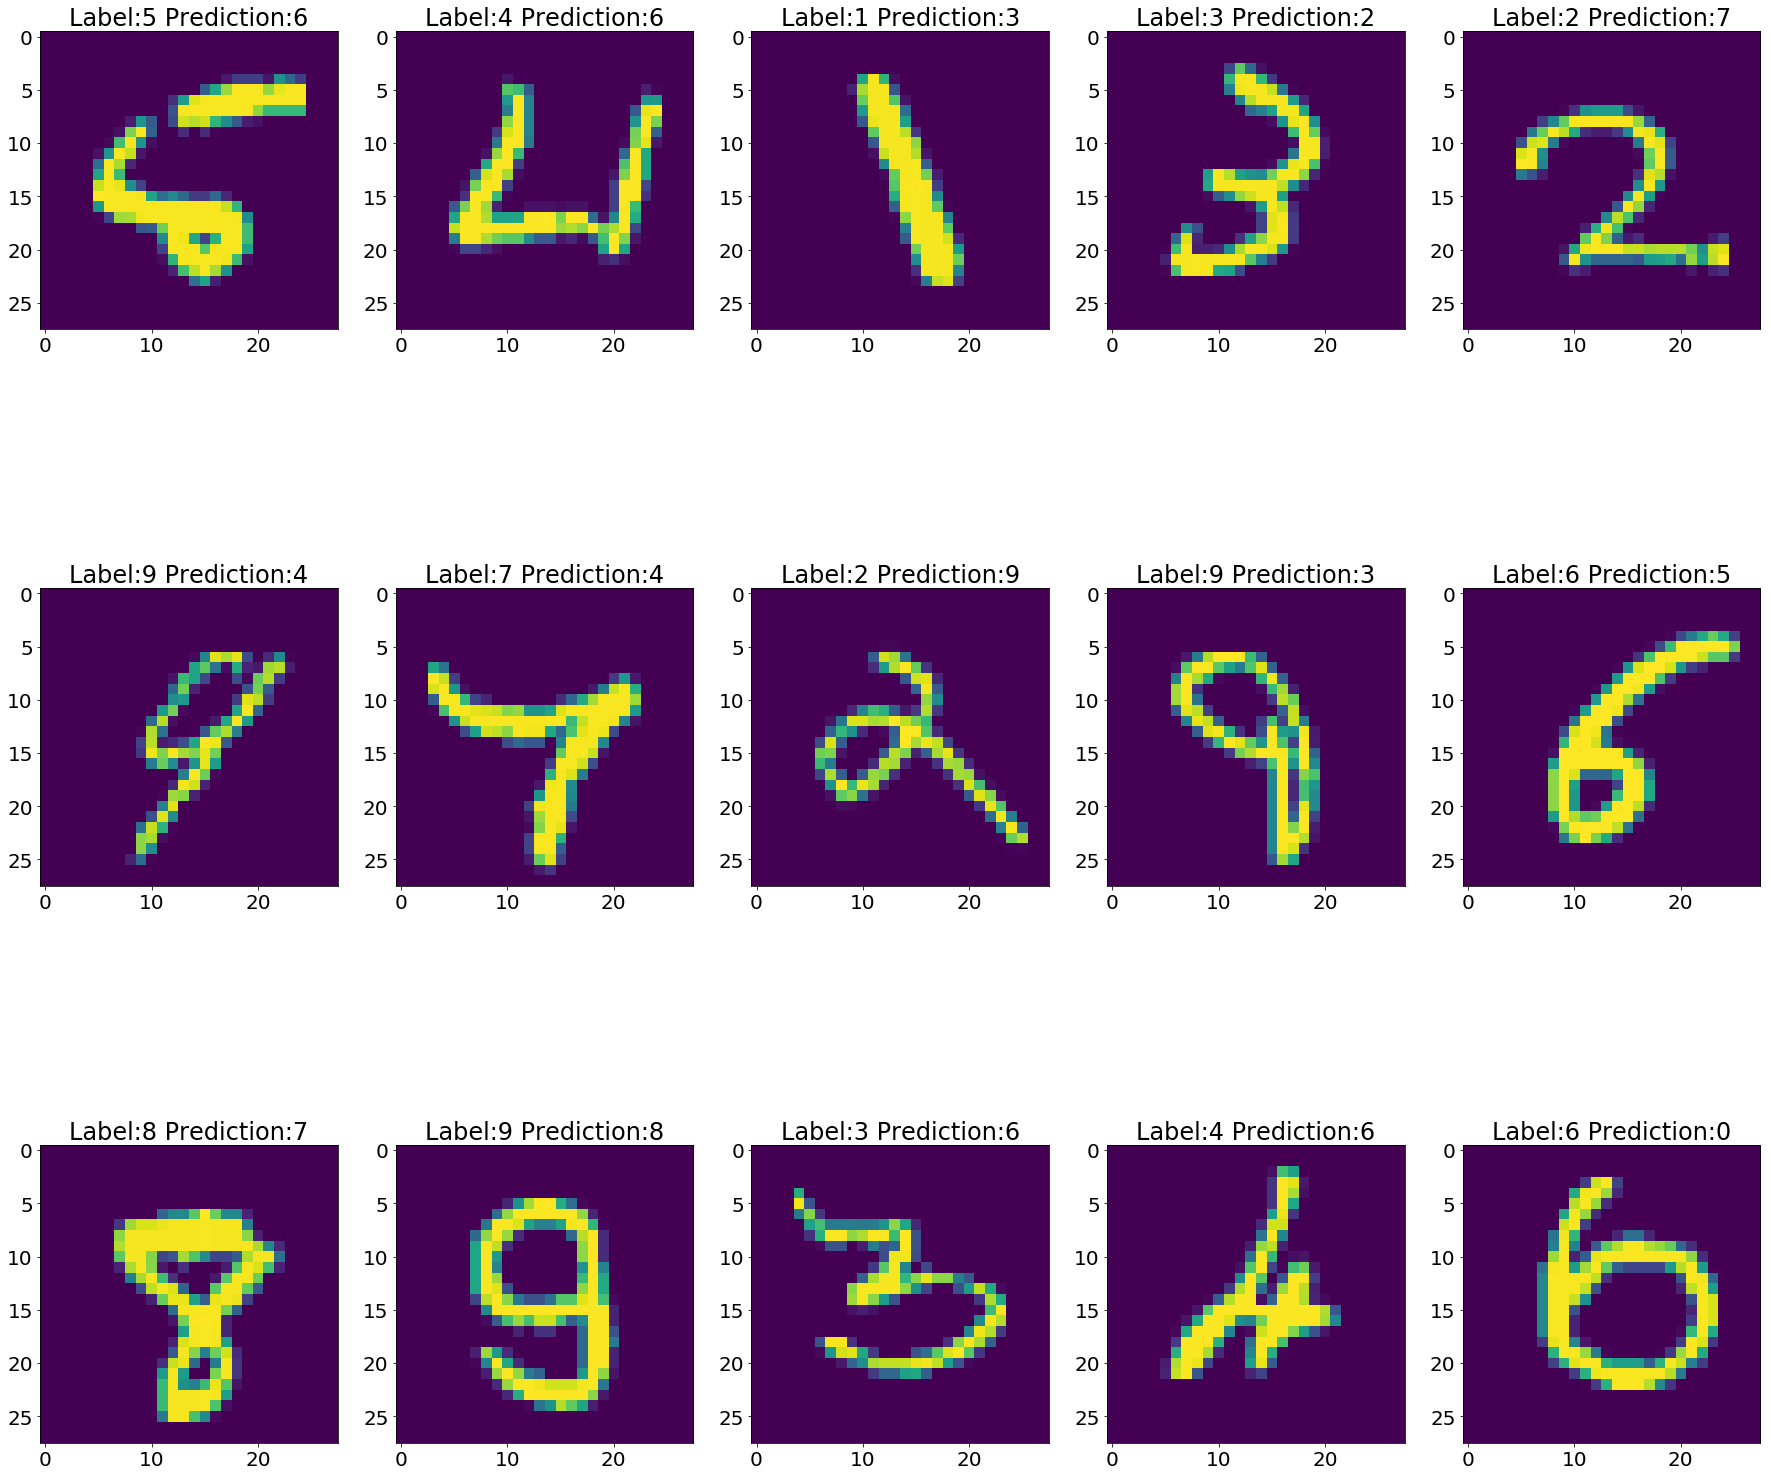

In [21]:
mistakes_indices = test_images_labels != pred
print("Proportion of errors:", np.mean(mistakes_indices), "Accuracy:",  np.mean(np.logical_not(mistakes_indices)))
indices_of_wrong_predictions = np.array(range(len(test_images_labels)))[mistakes_indices]   
print("Total wrong predictions:", len(indices_of_wrong_predictions))
show_digits(test_images, test_images_labels, pred, indices_of_wrong_predictions[ :15] )

Отметим для себя, что некоторые цифры представляют сложность в распознавании даже для человека и двинемся дальше.

## Нейронная сеть с одним скрытым ReLU-слоем и дропаутом

Будем использовать 100 нейронов на скрытом слое.

In [22]:
W_relu = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1), name="W_relu")
b_relu = tf.Variable(tf.truncated_normal([100], stddev=0.1), name="b_relu")
h = tf.nn.relu(tf.matmul(x, W_relu) + b_relu)

Будет полезен слой дропаута. Дропаут -- это слой, который выбрасывает (обнуляет) выходы некоторых нейронов, выбираемых случайно и заново для каждого обучающего примера. Все, что нужно сейчас задать -- это вероятность их выбрасывания. для этого сначала создадим заглушку:

In [23]:
keep_probability = tf.placeholder(tf.float32, name="keep_prob")
h_drop = tf.nn.dropout(h, keep_probability)

Теперь нейроны скрытого слоя будут участвовать в вычислениях с вероятностью `keep_propability`, а с вероятностью `1-keep_probability` их выход будет обнулен, и они не будут ни участвовать в предсказании для этого примера, ни обучаться на нем. 
Поскольку размер внутреннего слоя отличается от входного, придется немного поменять параметры внешнего слоя и, кроме того, переписать заключительный softmax-слой:

In [24]:
W = tf.Variable(tf.zeros([100, 10]), name="W2")
b = tf.Variable(tf.zeros([10]), name="b2")
y = tf.nn.softmax(tf.matmul(h_drop, W) + b)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
init = tf.global_variables_initializer()
sess.run(init)

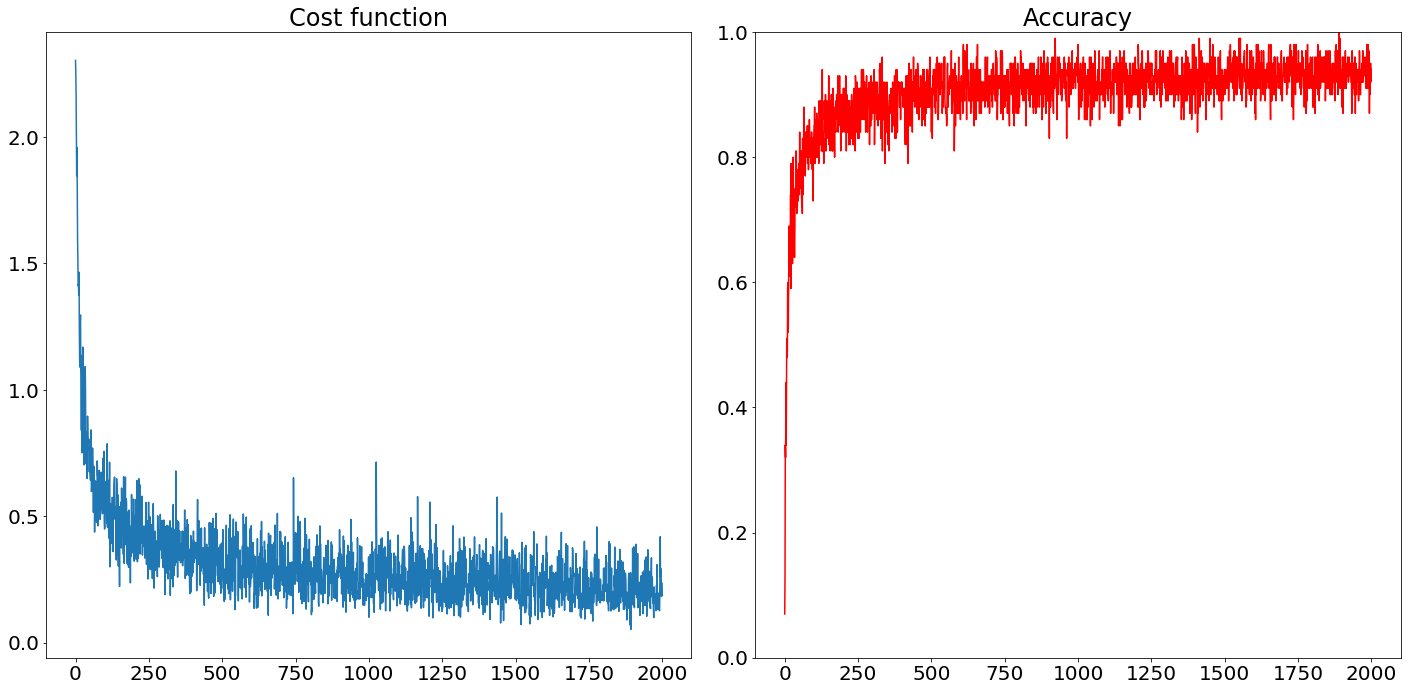

In [26]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cost_list = []
accuracy_list = []
n = 2000
for i in range(n):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, cost, accur = sess.run([train_step, cross_entropy, accuracy],
                              feed_dict={x: batch_xs, y_: batch_ys, keep_probability: 0.5})    
    #accur = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_probability:1.})
    cost_list.append(cost)
    accuracy_list.append(accur)
mpl.rcParams['font.size'] = 20    
ax1.plot(range(0, n), cost_list)
ax1.set_title("Cost function")
ax2.plot(range(0, n), accuracy_list, c='r')

ax2.set_title("Accuracy")
ax2.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [27]:
print("Accuracy:{0:.4f}".format(sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_probability:1.})))

Accuracy:0.9647


Видим, что результат улучшился с добавлением скрытого ReLU слоя с дропаутом. Попробуем увеличить число шагов до 3000

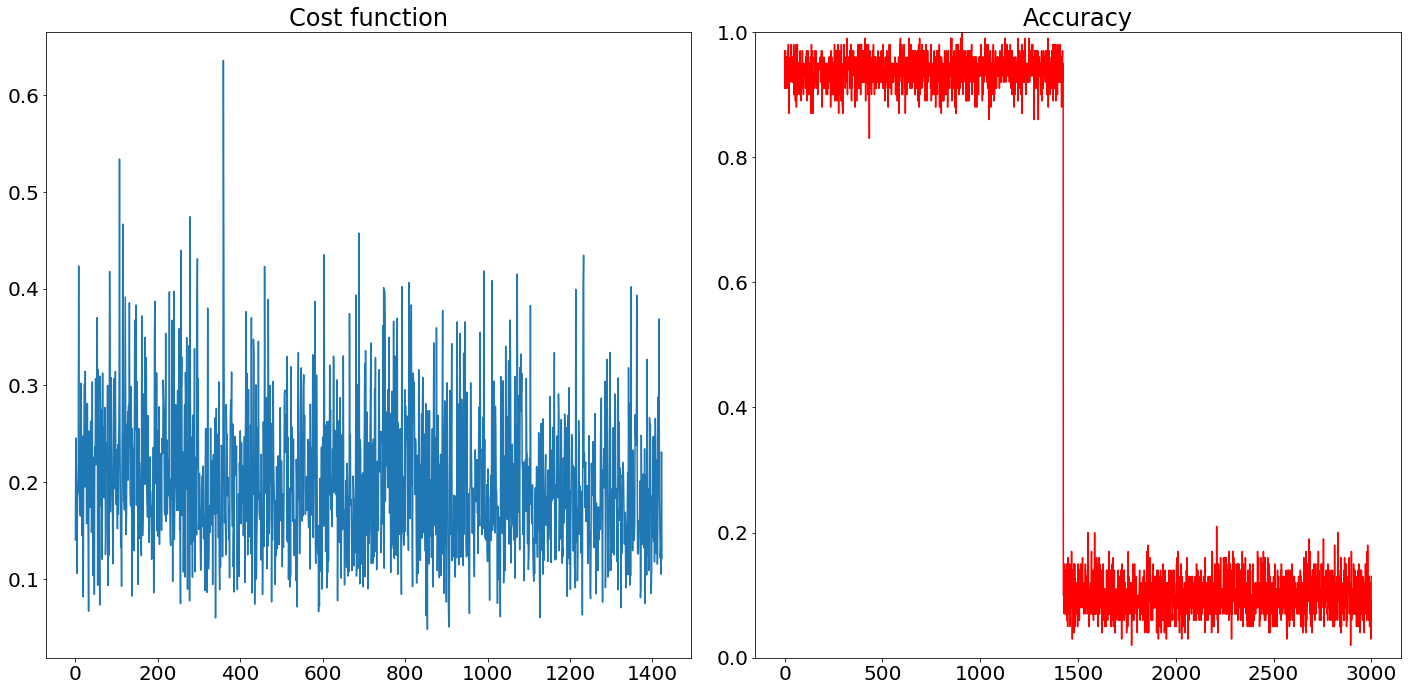

In [28]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cost_list = []
accuracy_list = []
n = 3000
for i in range(n):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, cost, accur = sess.run([train_step, cross_entropy, accuracy],
                              feed_dict={x: batch_xs, y_: batch_ys, keep_probability: 0.5})    
    #accur = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_probability:1.})
    cost_list.append(cost)
    accuracy_list.append(accur)
 
ax1.plot(range(0, n), cost_list)
ax1.set_title("Cost function")
ax2.plot(range(0, n), accuracy_list, c='r')

ax2.set_title("Accuracy")
ax2.set_ylim(0, 1)
plt.tight_layout()
plt.show()

Хм. Видим, что примерно с 1500-й итерации точность прогноза упала до 10%! Подозрительно похоже на случайное угадывание равномерно распределенных 10 классов. В чем может быть причина такого поведения? Первое что нужно проверить - не сломалась ли наша модель. Для этого можно, например, посмотреть на ее веса:

In [29]:
print(sess.run(b))

[nan nan nan nan nan nan nan nan nan nan]


In [30]:
print(sess.run(tf.argmax(y, axis=1), feed_dict={x:mnist.test.images, keep_probability:1.})) 
print(sess.run(cross_entropy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_probability:1.})) 
print("Accuracy:{0:.4f}".format(sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_probability:1.})))

[0 0 0 ... 0 0 0]
nan
Accuracy:0.0980


Действительно, элементы вектора сводобных членов $b$ перестали быть числами. Чаще всего это говорит о переполнении. Оно происходит, когда числа выходят за пределы соответствующих диапазонов и округляются до $\infty$. Чаще всего получается, когда очень маленькие числа округляются до нуля, а потом на этот ноль что-то делят. Но откуда переполнение возникло у нас?
У нас имеется два места, где могла возникнуть подобная ошибка - функция softmax и функция потерь. 

К счастью, в TensorFlow позаботились об этих трудностях и подготовили функцию, которая обходит все подвожные камни. Это функция `softmax_cross_entropy_with_logits_v2`. Воспользуемся ей и посмотрим улучшится ли точность предсказаний.

In [31]:
W_relu = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1), name="W_relu3")
b_relu = tf.Variable(tf.truncated_normal([100], stddev=0.1), name="b_relu3")

In [32]:
h_drop = tf.nn.dropout(h, keep_probability)

In [33]:
W = tf.Variable(tf.zeros([100, 10]), name="W3")
b = tf.Variable(tf.zeros([10]), name="b3")
logit = tf.matmul(h_drop, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logit))
y = tf.nn.softmax(tf.matmul(h_drop, W) + b)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [34]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [35]:
init = tf.global_variables_initializer()
sess.run(init)

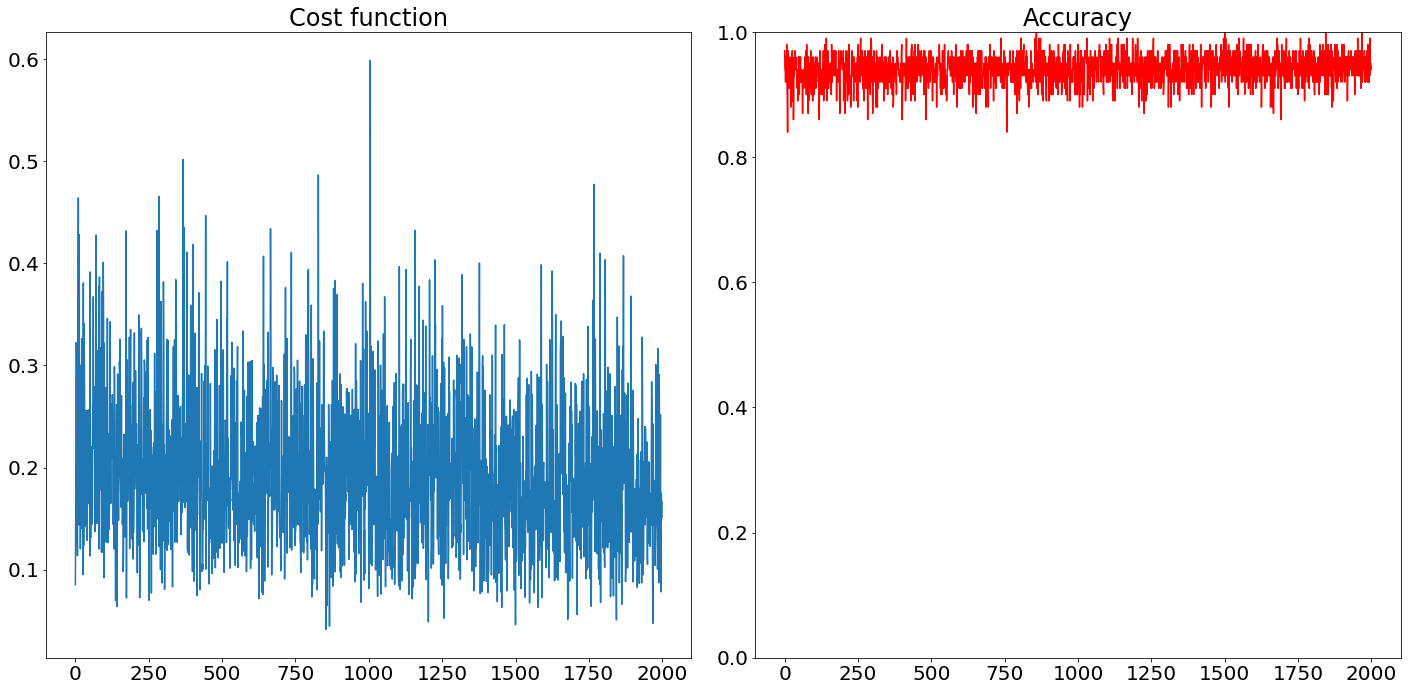

In [37]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cost_list = []
accuracy_list = []
n = 2000
for i in range(n):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, cost, accur = sess.run([train_step, cross_entropy, accuracy],
                              feed_dict={x: batch_xs, y_: batch_ys, keep_probability: 0.5})         
    cost_list.append(cost)
    accuracy_list.append(accur)

ax1.plot(range(0, n), cost_list)
ax1.set_title("Cost function")

ax2.plot(range(0, n), accuracy_list, c='r')
ax2.set_title("Accuracy")
ax2.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [38]:
print("Accuracy:{0:.4f}".format(sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_probability:1.})))

Accuracy:0.9700


Неплохо. Точность возрасла до 97%!

## Как инициализировать веса. Инициализации Ксавье и Хе

Результат сходимости градиентного спуска очень сильно зависит от начальных данных. Для симметричных функций активации с нулевым средним (в основном `tanh`) используйте инициализацию Ксавье, а для ReLU и ему подобных -- инициализацию Хе (`he_uniform`, `he_norm`)

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

Using TensorFlow backend.


In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

X_train = x_train.reshape([-1, 28*28])/255
X_test = x_test.reshape([-1, 28*28])/255

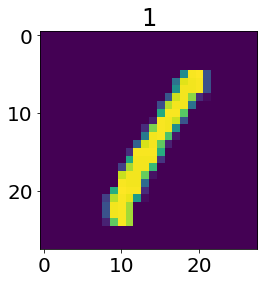

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
num_example = 3
ax1.set_title(y_train[num_example])
plt.imshow(x_train[num_example])
plt.show()

In [42]:
def create_model(init):
    model = Sequential()
    model.add(Dense(100, input_shape=(28*28, ), kernel_initializer=init, activation='tanh'))
    model.add(Dense(100, kernel_initializer=init, activation='tanh'))
    model.add(Dense(100, kernel_initializer=init, activation='tanh'))
    model.add(Dense(100, kernel_initializer=init, activation='tanh'))
    model.add(Dense(10, kernel_initializer=init, activation='softmax'))
    return model

In [7]:
uniform_model = create_model("uniform")
uniform_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
uniform_output = uniform_model.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 37s 620us/step - loss: 2.3006 - acc: 0.1124 - val_loss: 2.2986 - val_acc: 0.1135
Epoch 2/30
60000/60000 [==============================] - 8s 131us/step - loss: 2.2964 - acc: 0.1124 - val_loss: 2.2924 - val_acc: 0.1135
Epoch 3/30
60000/60000 [==============================] - 8s 136us/step - loss: 2.2764 - acc: 0.1573 - val_loss: 2.2194 - val_acc: 0.2244
Epoch 4/30
60000/60000 [==============================] - 8s 136us/step - loss: 1.8253 - acc: 0.3024 - val_loss: 1.3702 - val_acc: 0.4768
Epoch 5/30
60000/60000 [==============================] - 8s 136us/step - loss: 1.1588 - acc: 0.5879 - val_loss: 0.8919 - val_acc: 0.7187
Epoch 6/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.7919 - acc: 0.7445 - val_loss: 0.7022 - val_acc: 0.7868
Epoch 7/30
60000/60000 [==============================] - 8s 136us/step - loss: 0.6553 - acc: 0.8088 - val_loss: 0.5801 -

In [8]:
glorot_model = create_model("glorot_normal")
glorot_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
glorot_output = glorot_model.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.7044 - acc: 0.8215 - val_loss: 0.3863 - val_acc: 0.8954
Epoch 2/30
60000/60000 [==============================] - 9s 143us/step - loss: 0.3531 - acc: 0.9005 - val_loss: 0.3071 - val_acc: 0.9124
Epoch 3/30
60000/60000 [==============================] - 10s 166us/step - loss: 0.2973 - acc: 0.9142 - val_loss: 0.2727 - val_acc: 0.9208
Epoch 4/30
60000/60000 [==============================] - 9s 145us/step - loss: 0.2639 - acc: 0.9236 - val_loss: 0.2489 - val_acc: 0.9274
Epoch 5/30
60000/60000 [==============================] - 9s 152us/step - loss: 0.2385 - acc: 0.9304 - val_loss: 0.2241 - val_acc: 0.9351
Epoch 6/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.2169 - acc: 0.9371 - val_loss: 0.2080 - val_acc: 0.9392
Epoch 7/30
60000/60000 [==============================] - 9s 147us/step - loss: 0.1982 - acc: 0.9416 - val_loss: 0.1914 -

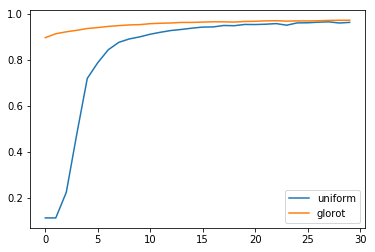

In [25]:
plt.plot(uniform_output.epoch, uniform_output.history['val_acc'])
plt.plot(glorot_output.epoch, glorot_output.history['val_acc'])
plt.legend(["uniform", "glorot"])

Из графика делаем вывод, что при инициализации Ксавье, точность предсказания на первой же итерации гораздо выше, чем при инициализации весов с помощью равномерного распределения.

## Нормализация по мини-батчам

Из-за большого числа слоев возникает проблема *внутреннего сдвига переменных* (internal covariance shift). Т.е. ситуация, когда все чему обучался нейрон текущего слоя, становится бесполезным из-за изменения в распределении значений нейронов предыдущего слоя. Для решения этой проблемы используют нормализацию по мини-батчам.

Однако нужно учесть тонкий момент. Если в качестве функции активации используется сигмоидальная функция $\sigma(x) = \frac{1}{1+e^{-x}}$, то когда мы нормализуем ее аргумент, мы увидим, что нелинейность почти пропадет: большинство нормализованных значений будут попадать в область, где сигмоида ведет себя как линейная функция. 

Чтобы компенсировать эти недостатки, слой нормализации должен быть способен работать как тождественная функция (т.е. при некоторых комбинациях параметров он должен иметь возможность со входами буквально ничего не делать). Чтобы так могло получиться вводятся параметры $\gamma_k$ и $\beta_k$ для масштабирования и сдвига нормализованной активации по каждой компоненте:
$$y_k = \gamma_k \frac{x_k - E[x_k]}{\sqrt{Var{[x_k]}}} + \beta_k$$

На практике, чтобы избежать деления на ноль при нормализации, к дисперсии добавляется небольшое эпсилон. 

In [43]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST/", one_hot=True)

def fullyconnected_layer(tensor, input_size, out_size):
    W = tf.Variable(tf.truncated_normal([input_size, out_size], stddev=0.1))
    b = tf.Variable(tf.truncated_normal([out_size], stddev=0.1))
    return tf.nn.tanh(tf.matmul(tensor, W) + b)

def batchnorm_layer(tensor, size):
    batch_mean, batch_var = tf.nn.moments(tensor, [0])
    beta = tf.Variable(tf.zeros([size]))
    scale = tf.Variable(tf.ones([size]))
    eps = 0.001
    return tf.nn.batch_normalization(tensor, batch_mean, batch_var, beta, scale, eps)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


Для эксперимента создадим полносвязную сеть с размерами слоев 784, 100, 100 и 10. Между промежуточными слоями мы и вставим слой нормализации по мини-батчам.

In [44]:
x = tf.placeholder(tf.float32, [None, 784])
h1 = fullyconnected_layer(x, 784, 100)
h1_bn = batchnorm_layer(h1, 100)
h2 = fullyconnected_layer(h1_bn, 100, 100)
y_logit = fullyconnected_layer(h2, 100, 10)

In [45]:
y = tf.placeholder(tf.float32, [None, 10])
#loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_logit))
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logit, labels=y)
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

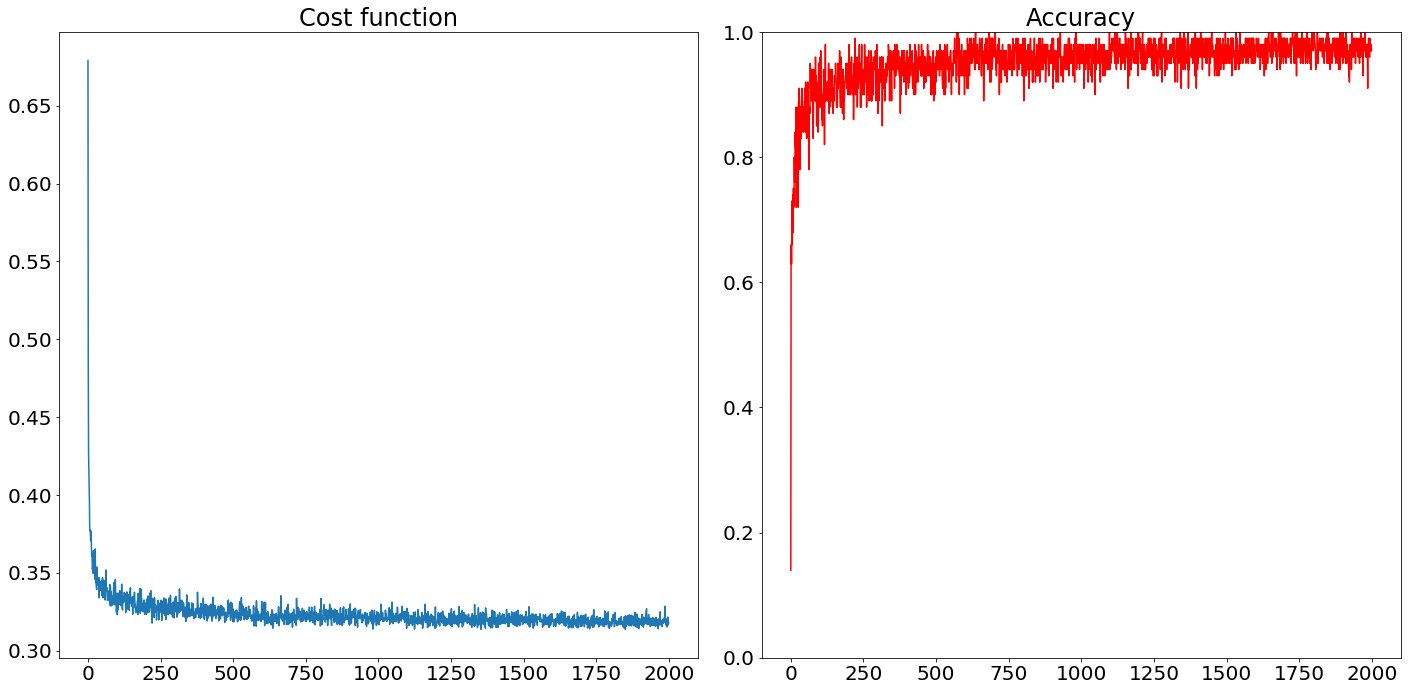

In [46]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cost_list = []
accuracy_list = []
n = 2000
for i in range(n):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, cost, accur = sess.run([train_op, loss, accuracy],
                              feed_dict={x: batch_xs, y: batch_ys})        
    #print(sess.run(y_logit, feed_dict={x: batch_xs}).shape)
    
    cost = sess.run(tf.reduce_mean(cost)) 
    #print(cost)
    cost_list.append(cost)
    accuracy_list.append(accur)

ax1.plot(range(0, n), cost_list)
ax1.set_title("Cost function")
ax2.plot(range(0, n), accuracy_list, c='r')

ax2.set_title("Accuracy")
ax2.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [47]:
print("Accuracy:{0:.4f}".format(sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels})))

Accuracy:0.9705


И снова точность 97%.

## Сверточная нейронная сеть для распознавания цифр

Посмотрим какой результат нам даст сверточная конфигурация нейронной сети.



In [49]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [50]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

Входные данные для двумерной свертки в TensoFlow должны иметь четырехмерную структуру, которая выглядит так:
$$[размер \: батча, \: высота, \: ширина, \: каналы]$$

А размерность тензора сверточных весов определяется размерами ядра свертки и числом каналов как на входе, так и на выходе. Получается снова четырехмерный тензор, но уже следующего вида:
$$[высота, \: ширина, \: входные \: каналы, \: выходные \: каналы]$$

Будем использовать 32 различных ядер свертки одного размера 5х5.

In [51]:
x_image = tf.reshape(x, [-1, 28, 28, 1])
W_conv_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv_1 = tf.Variable(tf.constant(0.1, shape=[32]))

Здесь $-1$ в `tf.reshape(x, [-1, 28, 28, 1])` означает заранее неизвестный размер мини-батча. А последняя единичка говорит нам о том, что канал всего лишь один, т.е. наши изображения монохромные. 

Теперь у нас определены переменные для всех весов сверточного слоя. Используем функцию `tf.nn.conv2d` для применения сверточных фильтров. Аргумент `strides` задает шаг по изображению. Зададим шаг 1 по всем размерностям. Аргумент `padding` говорит как быть с окнами, которые "вылезают" за границы входного массива.

In [52]:
conv_1 = tf.nn.conv2d(x_image, W_conv_1, strides=[1, 1, 1, 1], padding="SAME") + b_conv_1

В качестве функции активации возьмем ReLU

In [53]:
h_conv_1 = tf.nn.relu(conv_1)

Итак, слой фильтров с нелинейностью готов. Осталось только добавить слой субдискретизации (pooling). Обычно в качестве операции субдискретизации к каждой локальной группе нейронов применяется операция взятия максимума (max-pooling). 

Хотя в результате субдискретизации теряется часть информации, сеть становится более устойчивой к небольшим трансформациям изображения вроде сдвига и поворота. Параметр `ksize` задает размер окна субдискретизации по всем четыремя размерностям.

In [54]:
h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

Параметры `strides` и `padding`означают здесь то же самое, что в сверточном слое, только в этот раз мы двигаемся по изображению в обе стороны с шагом 2. Понятно, что после этого слоя размер изображения в обоиз направления уменьшится вдвое, до 14х14.

Теперь давайте добавим еще один сверточный слой и слой субдискретизации, в этот раз используем на этом слое 64 фильтра:


In [55]:
W_conv_2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv_2 = tf.Variable(tf.constant(0.1, shape=[64]))
conv_2 = tf.nn.conv2d(h_pool_1, W_conv_2, strides=[1, 1, 1, 1], padding="SAME") + b_conv_2

h_conv_2 = tf.nn.relu(conv_2)
h_pool_2 = tf.nn.max_pool(h_conv_2,  ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")#должно быть 7х7, но 14х14.Почему?

Как правило, в глубоких нейронных сетях за сверточным слоем следуют полносвязные, задача которых состоит в том, чтобы "собрать вместе" все признаки из фильтров и собственно перевести их в самый последний слой, который выдаст ответ. Но для начала нам нужно из двумерного слоя сделать плоский:

In [56]:
h_pool_2_flat = tf.reshape(h_pool_2, [-1, 7*7*64])

Число $7 \cdot  7 \cdot 64$ возникло из-за того, что мы дважды применили субдискретизацию и при этом в последнем слое использовали 64 фильтра. И теперь осталось только добавить полносвязные слои. Добавляем первый слой из 1024 нейронов

In [57]:
W_fc_1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc_1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc_1 = tf.nn.relu(tf.matmul(h_pool_2_flat, W_fc_1) + b_fc_1)

Регуляризуем его дропаутом:

In [58]:
keep_propability = tf.placeholder(tf.float32, name="keep_prob")
h_fc_1_drop = tf.nn.dropout(h_fc_1, keep_propability)

Теперь добавляем последний слой с десятью выходами:

In [59]:
W_fc_2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc_2 = tf.Variable(tf.constant(0.1, shape=[10]))

logit_conv = tf.matmul(h_fc_1_drop, W_fc_2) + b_fc_2
y_conv = tf.nn.softmax(logit_conv)

Осталось определить ошибку и ввести оптимизатор. Используем алгоритм адаптивного градиентонго спуска `Adam`. Его идея в том, что шаг изменения должен быть меньше у тех весов, котоыре в большей степени варьируются в данных, и больше у тех, которые менее изменчиввы в разных примерах.

In [62]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit_conv, labels=y))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

In [63]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [64]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [65]:
import numpy as np 
for i in range(10000):
    #rand_indexes = np.random.choice(range(X_train.shape[0]), batch_size)
    #batch_xs, batch_ys = X_train[rand_indexes].reshape(batch_size, 784), Y_train[rand_indexes].reshape(batch_size, 10)
    batch_xs, batch_ys = mnist.train.next_batch(64)
    sess.run(train_step, feed_dict = {x:batch_xs, y:batch_ys, keep_propability:0.5})

In [67]:
#sess.run(accuracy, feed_dict = {x: mnist.test.images, y: mnist.test.labels, keep_propability: 1.} ) # так не работает из-за нехватки памяти на GPU
error_rate_1 = sess.run(accuracy, feed_dict={x:mnist.test.images[:5000], y: mnist.test.labels[:5000], keep_propability: 1.})
error_rate_2 = sess.run(accuracy, feed_dict={x:mnist.test.images[5000:], y: mnist.test.labels[5000:], keep_propability: 1.})
error_rate = (error_rate_1 + error_rate_2)/2
print(error_rate)


0.990399956703186


In [37]:
#error_rate_1 = sess.run(accuracy, feed_dict = {x: X_test.reshape(10000, 784)[:5000], y: Y_test.reshape(10000, 10)[:5000], keep_propability: 1.})
#error_rate_2 = sess.run(accuracy, feed_dict = {x: X_test.reshape(10000, 784)[5000:], y: Y_test.reshape(10000, 10)[5000:], keep_propability: 1.})
#error_rate = (error_rate_1 + error_rate_2)/2
#print(error_rate)

0.9922000169754028


Точность улучшилась до 99%!

## Keras

Попробуем то же самое сделать в Keras

In [68]:
from keras.datasets import mnist
#mnist = tf.keras.datasets.mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D, Conv2D
from keras.utils import np_utils

In [69]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
batch_size, img_rows, img_cols = 64, 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [70]:
model = Sequential()

model.add(Conv2D(32, (5, 5),  input_shape=input_shape, padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Conv2D(64, (5, 5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

In [71]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.1254 - acc: 0.9611 - val_loss: 0.0353 - val_acc: 0.9887
Epoch 2/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0433 - acc: 0.9868 - val_loss: 0.0280 - val_acc: 0.9915
Epoch 3/10
60000/60000 [==============================] - 74s 1ms/step - loss: 0.0304 - acc: 0.9905 - val_loss: 0.0243 - val_acc: 0.9925
Epoch 4/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0235 - acc: 0.9928 - val_loss: 0.0405 - val_acc: 0.9876
Epoch 5/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0192 - acc: 0.9939 - val_loss: 0.0245 - val_acc: 0.9919
Epoch 6/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0163 - acc: 0.9949 - val_loss: 0.0233 - val_acc: 0.9927
Epoch 7/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0284 - val_acc

In [74]:
print("Test loss score: %f" % score[0])
print("Test accuracy: %f" % score[1])

Test loss score: 0.029680
Test accuracy: 0.991700


Как и ожидалось, точность получилась сравнимая - примерно те же 99%. Однако заметим, что в процессе обучения модели достигались и более высокие результаты, однако мы не остановили процесс подгонки. Потому мы можем использовать другой подход, а именно остановить процесс обучения как только достигнем наилучшей точности.

In [73]:
from keras.callbacks import ModelCheckpoint
model.fit(X_train, Y_train, 
          callbacks=[ModelCheckpoint("model.hdf5", monitor="val_acc",
                                     save_best_only=True, save_weights_only=False, mode="auto")],
          validation_split=0.1, epochs=1, batch_size=64)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 63s 1ms/step - loss: 0.0086 - acc: 0.9971 - val_loss: 0.0082 - val_acc: 0.9980


In [75]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [76]:
print("Test loss score: %f" % score[0])
print("Test accuracy: %f" % score[1])

Test loss score: 0.025689
Test accuracy: 0.992400


Итого, точность немного подросла - до 99.24%.